In [3]:
from platform import python_version
import tensorflow as tf

print(tf.test.is_gpu_available())
print(python_version())

True
3.7.5


In [4]:
import os
import numpy as np
from os import listdir
from PIL import Image
import time
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from keras import backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [5]:
path="datasets/TSKinFace_Data/TSKinFace_cropped/"
randomiser = np.random.RandomState(123)

In [101]:
img_size = 64
mean = 0.0009
std_dev = 0.009
lr = 0.0005
b1 = 0.875
b2 = 0.975
sd_random_normal_init = 0.02

EPOCHS = 10
batch = 10

In [86]:
def generate_image(family_dir, family_number, gender):
    dic={}
    sub = ["F" , "M", gender]
    family_pth = path+"/"+family_dir+"/" + family_dir + "-" + str(family_number) + "-"
    for ele in sub:
        addr = family_pth+ele+".jpg"
        original_img = np.array(Image.open(addr))
        if ele =='F':
            dic['father'] = original_img
        elif ele == 'M':
            dic['mother'] = original_img
        elif ele == 'S':
            dic['child'] = original_img    
            dic['gender']=np.zeros((original_img.shape))
        elif ele == 'D':
            dic['child'] = original_img    
            dic['gender'] = np.ones((original_img.shape))
    return [dic['father'],dic['mother'],dic['gender'],dic['child']]

def generate_batch(families_batch):
    np_images=[]
    for family in families_batch:
        res = generate_image(family[0], family[1], family[2])
        if( res != None):
            np_images.append(res)
    return np_images

In [87]:
all_families = []
for i in range(285):
    all_families.append(['FMS', i+1, 'S'])
for i in range(274):
    all_families.append(['FMD', i+1, 'D'])
for i in range(228):
    all_families.append(['FMSD', i+1, 'D'])  
    all_families.append(['FMSD', i+1, 'S'])  
randomiser.shuffle(all_families)
train_families = all_families[:-10]
test_families = all_families[-10:]

In [88]:
OUTPUT_CHANNELS = 3

In [89]:
def gen_downsample_parent(filters, size, apply_batchnorm=True, apply_dropout=False):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.ELU())
        
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(rate = 0.5))

    return result

In [90]:
def gen_upsample(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.ELU())

    return result

In [91]:
def EncoderNN():
    down_stack_parent = [
    gen_downsample_parent(32,4,apply_batchnorm=True, apply_dropout=False),
    gen_downsample_parent(64,4,apply_batchnorm=True, apply_dropout=False)
    ]
    
#     down_stack_noise =[
# #   z = 4x4x64
#     gen_downsample_noise(64,4,apply_batchnorm=True), #8x8x64
#     gen_downsample_noise(32,4,apply_batchnorm=True) #16x16x32      
#     ]
    
    final_conv =[
        gen_upsample(32,4 ,apply_batchnorm = True)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

    concat = tf.keras.layers.Concatenate()

    father = tf.keras.layers.Input(shape=(img_size,img_size,3))
    mother = tf.keras.layers.Input(shape=(img_size,img_size,3))

    
    
    x1 = father
    for down in down_stack_parent:
        x1 = down(x1)
    
#     print(x1.shape)
    
    x2 = mother
    for down in down_stack_parent:
        x2 = down(x2) 
    
#     print(x2.shape)
    
    final = concat([x1,x2])
#     print(final.shape)
    final = final_conv[0](final)
    
    final = last(final)
#     print(final.shape)
    return tf.keras.Model(inputs=[father, mother], outputs=final)

In [92]:
encoder = EncoderNN()

In [93]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1=b1)

In [94]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [95]:
def train_encoder(father_batch, mother_batch, target_batch, b_size):
    with tf.GradientTape() as enc_tape:
        gen_outputs = encoder([father_batch, mother_batch], training=True)
        
        diff = tf.abs(target_batch - gen_outputs)
        flatten_diff = tf.reshape(diff, (b_size, img_size*img_size*3))
        
        encoder_loss_batch = tf.reduce_mean(flatten_diff, axis=1)
        encoder_loss = tf.reduce_mean(encoder_loss_batch)
    
    print("ENCODER_LOSS: ",tensor_to_array(encoder_loss))
    #calculate gradients
    encoder_gradients = enc_tape.gradient(encoder_loss,encoder.trainable_variables)

    #apply gradients on optimizer
    encoder_optimizer.apply_gradients(zip(encoder_gradients,encoder.trainable_variables))
    


In [96]:
def fit_encoder(train_ds, epochs, test_ds, batch):
    losses=np.array([])
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch+1))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))
            batch_data = batch_data / 255 * 2 -1
            
            
            print("Generated batch", batch_data.shape)

            X_Father_train = tf.convert_to_tensor(batch_data[:,0],dtype =tf.float32)
            X_Mother_train = tf.convert_to_tensor(batch_data[:,1],dtype =tf.float32)
            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            
            train_encoder(X_Father_train, X_Mother_train, Y_train,batch)
            
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
    print("______________________________TRAINING COMPLETED_______________________________")

In [102]:
train_dataset = all_families[:-100]
test_dataset = all_families[-100:]
encoder = EncoderNN()

with tf.device('/gpu:0'):
    fit_encoder(train_dataset, EPOCHS, test_dataset,batch)

______________________________EPOCH 1_______________________________
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.39809808
Trained for batch 1/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.4123927
Trained for batch 2/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.38227683
Trained for batch 3/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.38198575
Trained for batch 4/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36186895
Trained for batch 5/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.38534036
Trained for batch 6/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35905164
Trained for batch 7/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.38357583
Trained for batch 8/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.38280118
Trained for batch 9/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3578781
Trained for batch 10/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30952078
Trained for batch 11/91
Generat

Trained for batch 5/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3164851
Trained for batch 6/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32408908
Trained for batch 7/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35737908
Trained for batch 8/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30791268
Trained for batch 9/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34091455
Trained for batch 10/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.2804095
Trained for batch 11/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29674232
Trained for batch 12/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31122372
Trained for batch 13/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33586115
Trained for batch 14/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.28936988
Trained for batch 15/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.28088254
Trained for batch 16/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.27185482
Trained for batch 11/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29328245
Trained for batch 12/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31099367
Trained for batch 13/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33467585
Trained for batch 14/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29520014
Trained for batch 15/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.2689888
Trained for batch 16/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30519485
Trained for batch 17/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31370145
Trained for batch 18/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3219652
Trained for batch 19/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29604727
Trained for batch 20/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29176694
Trained for batch 21/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29536146
Traine

ENCODER_LOSS:  0.29255843
Trained for batch 20/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.2871198
Trained for batch 21/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29374486
Trained for batch 22/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3102852
Trained for batch 23/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30902544
Trained for batch 24/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31026274
Trained for batch 25/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3329157
Trained for batch 26/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.28297496
Trained for batch 27/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3088557
Trained for batch 28/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33381325
Trained for batch 29/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.28942898
Trained for batch 30/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35011607
Trained for batch 31/91
Generated batch (10

ENCODER_LOSS:  0.33157468
Trained for batch 26/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.28165248
Trained for batch 27/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3073903
Trained for batch 28/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33183083
Trained for batch 29/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.2878634
Trained for batch 30/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34830612
Trained for batch 31/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32104158
Trained for batch 32/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3212658
Trained for batch 33/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33405453
Trained for batch 34/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29357105
Trained for batch 35/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29605418
Trained for batch 36/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3263097
Trained for batch 37/91
Generated batch (10

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32184416
Trained for batch 32/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32078257
Trained for batch 33/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33373946
Trained for batch 34/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29307503
Trained for batch 35/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.2948005
Trained for batch 36/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32436147
Trained for batch 37/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.27876467
Trained for batch 38/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30604565
Trained for batch 39/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32585496
Trained for batch 40/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.27189165
Trained for batch 41/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30238464
Trained for batch 42/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30808112
Train

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30487913
Trained for batch 39/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32446647
Trained for batch 40/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.27060524
Trained for batch 41/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30110615
Trained for batch 42/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3078661
Trained for batch 43/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3074365
Trained for batch 44/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33308285
Trained for batch 45/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31508836
Trained for batch 46/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33831024
Trained for batch 47/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.28803068
Trained for batch 48/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3275783
Trained for batch 49/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.2905867
Trained 

ENCODER_LOSS:  0.28686157
Trained for batch 48/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32739058
Trained for batch 49/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.2899248
Trained for batch 50/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.2897531
Trained for batch 51/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30918765
Trained for batch 52/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29205123
Trained for batch 53/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3289465
Trained for batch 54/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33454338
Trained for batch 55/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31370372
Trained for batch 56/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3061252
Trained for batch 57/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33603224
Trained for batch 58/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3466815
Trained for batch 59/91
Generated batch (10,

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3125916
Trained for batch 56/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3051471
Trained for batch 57/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33498394
Trained for batch 58/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34554058
Trained for batch 59/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.28264192
Trained for batch 60/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.26852965
Trained for batch 61/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.2698656
Trained for batch 62/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32201543
Trained for batch 63/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34045306
Trained for batch 64/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.28324455
Trained for batch 65/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31191275
Trained for batch 66/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33617073
Trained

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.26764512
Trained for batch 61/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.2689747
Trained for batch 62/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32131493
Trained for batch 63/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33939603
Trained for batch 64/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.28285939
Trained for batch 65/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31121105
Trained for batch 66/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33587208
Trained for batch 67/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30629858
Trained for batch 68/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.28069
Trained for batch 69/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31481177
Trained for batch 70/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29990748
Trained for batch 71/91
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32719213
Trained 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.8735933
0.86163896


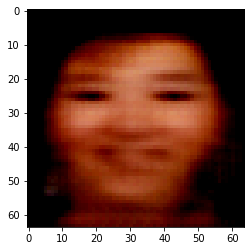

In [103]:
family_no = 1014
family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]
with tf.device('/gpu:0'):
    gen_output = encoder([father_inp, mother_inp], training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

###############################################################################################################################

In [104]:
def disc_downsample_parent_target(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))

    return result

In [105]:
def disc_loss(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))
    
    return result

In [106]:
def Discriminator():

    father = tf.keras.layers.Input(shape=(img_size,img_size,3))
    mother = tf.keras.layers.Input(shape=(img_size,img_size,3))
    target = tf.keras.layers.Input(shape=(img_size,img_size,3))
    
    down_stack_parent_target = [
    disc_downsample_parent_target(32,4,apply_batchnorm=False), #32x32x32
    disc_downsample_parent_target(64,4,apply_batchnorm=True)   #16x16x64
    ]
    
    down_stack_combined =[
    disc_loss(192,4,apply_batchnorm=True),
    disc_loss(256,4,apply_batchnorm=False)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,padding='same',
                                  kernel_initializer=initializer) # linear layer
    
    
    concat = tf.keras.layers.Concatenate()
    x1 = father
    for down in down_stack_parent_target:
        x1 = down(x1)
    
    x2 = mother
    for down in down_stack_parent_target:
        x2 = down(x2)
        
    x3 = target
    for down in down_stack_parent_target:
        x3 = down(x3)
    
    combined = concat([x1,x2,x3])
    # combined is Batchx16x16x192
    
    x4 = combined
    for down in down_stack_combined:
        x4 = down(x4)
#     print(x4.shape)
    
    output = last(x4) #4X4 
#     print(output.shape)

    return tf.keras.Model(inputs=[father,mother,target], outputs=output)

In [107]:
discriminator = Discriminator()

In [108]:
# family_data = generate_image(all_families[126])
# p1 = tf.cast(family_data[0], tf.float32)
# p2 = tf.cast(family_data[1], tf.float32)
# c = tf.cast(family_data[2], tf.float32)

# discriminator = Discriminator()
# with tf.device('/cpu:0'):
#     disc_out = discriminator(inputs = [p1,p2,c], training=True)

In [109]:
LAMBDA = 100

In [110]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [111]:
def discriminator_loss(disc_real_output, disc_generated_output,b_size):
    real_loss_diff = tf.abs(tf.ones_like(disc_real_output) - disc_real_output)
    real_flatten_diff = tf.reshape(real_loss_diff, (b_size, 4*4*1))
    real_loss_batch = tf.reduce_mean(real_flatten_diff, axis=1)
    real_loss = tf.reduce_mean(real_loss_batch)
    
    gen_loss_diff = tf.abs(tf.zeros_like(disc_generated_output) - disc_generated_output)
    gen_flatten_diff = tf.reshape(gen_loss_diff, (b_size, 4*4*1))
    gen_loss_batch = tf.reduce_mean(gen_flatten_diff, axis=1)
    gen_loss = tf.reduce_mean(gen_loss_batch)

    total_disc_loss = real_loss + gen_loss
    return total_disc_loss

In [112]:
def generator_loss(disc_generated_output, gen_output, target,b_size):
    gen_loss_diff = tf.abs(tf.ones_like(disc_generated_output) - disc_generated_output)
    gen_flatten_diff = tf.reshape(gen_loss_diff, (b_size, 4*4*1))
    gen_loss_batch = tf.reduce_mean(gen_flatten_diff, axis=1)
    gen_loss = tf.reduce_mean(gen_loss_batch)
    
    l1_loss_diff = tf.abs(target - gen_output)
    l1_flatten_diff = tf.reshape(l1_loss_diff, (b_size, img_size*img_size*3))
    l1_loss_batch = tf.reduce_mean(l1_flatten_diff, axis=1)
    l1_loss = tf.reduce_mean(l1_loss_batch)
 
    total_gen_loss = l1_loss + LAMBDA * gen_loss  
#     print("Reconstruction loss: {}, GAN loss: {}".format(l1_loss, gen_loss))
    return total_gen_loss

In [113]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=b1 ,beta_2 = b2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=b1, beta_2 = b2)

In [143]:
def train_step(father_batch, mother_batch, target_batch,b_size):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_outputs = encoder([father_batch, mother_batch], training=True)
#         print("Generated outputs",gen_outputs.shape)
        
        disc_real_output = discriminator([father_batch, mother_batch, target_batch], training=True)
#         print("disc_real_output ", disc_real_output.shape)
        
        disc_generated_output = discriminator([father_batch, mother_batch, gen_outputs], training=True)
#         print("disc_generated_output ", disc_generated_output.shape)
        
        gen_loss =  generator_loss(disc_generated_output, gen_outputs, target_batch,b_size)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output,b_size)
    
        
    print("GEN_LOSS",tensor_to_array(gen_loss))
    print("DISC_LOSS",tensor_to_array(disc_loss))

    generator_gradients = gen_tape.gradient(gen_loss,encoder.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,encoder.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

In [144]:
def fit(train_ds, epochs, test_ds,batch):
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))
            batch_data = batch_data / 255 * 2 -1
            
            print("Generated batch", batch_data.shape)

            X_father_train = tf.convert_to_tensor(batch_data[:,0],dtype =tf.float32)
            X_mother_train = tf.convert_to_tensor(batch_data[:,1],dtype =tf.float32)
#             print("Xtrain",X_train.shape)
#             print("Batch converted to tensor")

            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            train_step(X_father_train, X_mother_train, Y_train, batch)
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
            
#         family_no = 400
#         family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
#         inp = [family_data[0],family_data[1]]
#         inp = tf.cast(inp, tf.float32)
#         father_inp = inp[0][tf.newaxis,...]
#         mother_inp = inp[1][tf.newaxis,...]
#         gen_output = encoder([father_inp, mother_inp], training=True)
#         print(tf.reduce_min(gen_output))
#         print(tf.reduce_max(gen_output))
#         plt.figure()
#         plt.imshow(gen_output[0,...])
#         plt.show()
        
    print("______________________________TRAINING COMPLETED_______________________________")
    checkpoint.save(file_prefix = checkpoint_prefix)

In [153]:
concat = tf.keras.layers.Concatenate()

In [154]:
train_dataset = all_families[:-10]
test_dataset = all_families[-10:]
encoder = EncoderNN()
discriminator = Discriminator()

In [155]:
img_size = 64
mean = 0.0009
std_dev = 0.009
lr = 0.0005
b1 = 0.875
b2 = 0.975
sd_random_normal_init = 0.02

EPOCHS = 8
batch = 5

In [156]:
checkpoint_dir = './checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=encoder,
                                 discriminator=discriminator)

In [157]:
with tf.device('/gpu:0'):
    fit(train_dataset, EPOCHS, test_dataset,batch)

______________________________EPOCH 0_______________________________
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 156.7639
DISC_LOSS 3.3547964
Trained for batch 1/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 424.88986
DISC_LOSS 8.093582
Trained for batch 2/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 193.42468
DISC_LOSS 3.156067
Trained for batch 3/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 119.93564
DISC_LOSS 1.8820612
Trained for batch 4/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 98.2579
DISC_LOSS 2.4016337
Trained for batch 5/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 86.948326
DISC_LOSS 2.2598476
Trained for batch 6/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 74.38813
DISC_LOSS 1.6795082
Trained for batch 7/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 123.35092
DISC_LOSS 1.8713812
Trained for batch 8/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 160.88182
DISC_LOSS 2.2190673
Trained for batch 9/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 101.17787
DISC_LOSS 1

Trained for batch 84/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 60.059624
DISC_LOSS 0.77985173
Trained for batch 85/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 75.25123
DISC_LOSS 0.75103974
Trained for batch 86/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 80.12653
DISC_LOSS 0.6997866
Trained for batch 87/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 63.778442
DISC_LOSS 0.8017733
Trained for batch 88/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 64.3266
DISC_LOSS 0.9045301
Trained for batch 89/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 41.64721
DISC_LOSS 1.3747926
Trained for batch 90/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 43.34514
DISC_LOSS 1.2968552
Trained for batch 91/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 74.22571
DISC_LOSS 1.0139501
Trained for batch 92/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 85.58025
DISC_LOSS 0.9038948
Trained for batch 93/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 83.16962
DISC_LOSS 0.86720127
Trained for batch 94/201
G

Trained for batch 169/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 94.61768
DISC_LOSS 0.29098064
Trained for batch 170/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 98.04857
DISC_LOSS 0.39826727
Trained for batch 171/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 87.94052
DISC_LOSS 0.3411555
Trained for batch 172/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 91.98937
DISC_LOSS 0.3538719
Trained for batch 173/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 95.84491
DISC_LOSS 0.397004
Trained for batch 174/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 94.462715
DISC_LOSS 0.37885582
Trained for batch 175/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 103.14725
DISC_LOSS 0.5947081
Trained for batch 176/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 89.06927
DISC_LOSS 0.31761765
Trained for batch 177/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 90.35392
DISC_LOSS 0.34178615
Trained for batch 178/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 80.2267
DISC_LOSS 0.5210935
Trained for bat

GEN_LOSS 51.310955
DISC_LOSS 0.95521396
Trained for batch 53/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 61.71784
DISC_LOSS 0.76424986
Trained for batch 54/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 65.35826
DISC_LOSS 0.63782895
Trained for batch 55/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 63.497894
DISC_LOSS 0.8006575
Trained for batch 56/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 93.023994
DISC_LOSS 0.5179283
Trained for batch 57/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 97.692894
DISC_LOSS 0.5074691
Trained for batch 58/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 91.00443
DISC_LOSS 0.46881914
Trained for batch 59/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 74.99157
DISC_LOSS 0.6174191
Trained for batch 60/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 83.99207
DISC_LOSS 0.6230124
Trained for batch 61/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 95.45399
DISC_LOSS 0.610029
Trained for batch 62/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 85.83355
DISC_

GEN_LOSS 43.948933
DISC_LOSS 0.92914027
Trained for batch 137/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 35.924816
DISC_LOSS 1.0089408
Trained for batch 138/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 37.046787
DISC_LOSS 0.95592606
Trained for batch 139/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 61.87155
DISC_LOSS 0.78471196
Trained for batch 140/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 62.09823
DISC_LOSS 0.93952215
Trained for batch 141/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 73.38928
DISC_LOSS 0.80998325
Trained for batch 142/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 75.49787
DISC_LOSS 0.5791384
Trained for batch 143/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 67.47906
DISC_LOSS 0.5480255
Trained for batch 144/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 78.9403
DISC_LOSS 0.570974
Trained for batch 145/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 92.46648
DISC_LOSS 0.49055603
Trained for batch 146/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 86.9

GEN_LOSS 77.32096
DISC_LOSS 0.49664688
Trained for batch 21/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 83.34165
DISC_LOSS 0.45990974
Trained for batch 22/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 111.09456
DISC_LOSS 0.7373071
Trained for batch 23/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 108.60472
DISC_LOSS 0.43903446
Trained for batch 24/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 89.77435
DISC_LOSS 0.42720956
Trained for batch 25/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 73.82785
DISC_LOSS 0.59767985
Trained for batch 26/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 76.3268
DISC_LOSS 0.4986993
Trained for batch 27/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 81.11247
DISC_LOSS 0.46586794
Trained for batch 28/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 91.75001
DISC_LOSS 0.397659
Trained for batch 29/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 82.34168
DISC_LOSS 0.6723213
Trained for batch 30/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 97.90156
DISC_L

Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 103.78412
DISC_LOSS 0.6231414
Trained for batch 105/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 112.75025
DISC_LOSS 0.3862672
Trained for batch 106/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 100.99914
DISC_LOSS 0.3978556
Trained for batch 107/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 88.13325
DISC_LOSS 0.46755862
Trained for batch 108/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 79.0384
DISC_LOSS 0.44246417
Trained for batch 109/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 99.70196
DISC_LOSS 0.49654734
Trained for batch 110/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 115.7385
DISC_LOSS 0.42835352
Trained for batch 111/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 104.98805
DISC_LOSS 0.36885828
Trained for batch 112/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 100.580215
DISC_LOSS 0.31695256
Trained for batch 113/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 90.33604
DISC_LOSS 0.30209482
Trained for batch 114/201
Generate

Trained for batch 188/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 81.0214
DISC_LOSS 0.5381936
Trained for batch 189/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 76.53035
DISC_LOSS 0.43392068
Trained for batch 190/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 88.855835
DISC_LOSS 0.39613998
Trained for batch 191/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 99.3766
DISC_LOSS 0.37405616
Trained for batch 192/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 104.09327
DISC_LOSS 0.49159437
Trained for batch 193/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 109.37769
DISC_LOSS 0.4587857
Trained for batch 194/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 91.10695
DISC_LOSS 0.37869963
Trained for batch 195/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 86.47757
DISC_LOSS 0.36955512
Trained for batch 196/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 83.03066
DISC_LOSS 0.4350546
Trained for batch 197/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 87.23151
DISC_LOSS 0.39254373
Trained for 

Trained for batch 71/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 84.82679
DISC_LOSS 0.42157376
Trained for batch 72/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 87.72564
DISC_LOSS 0.5012399
Trained for batch 73/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 99.27254
DISC_LOSS 0.61048615
Trained for batch 74/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 98.59933
DISC_LOSS 0.7121498
Trained for batch 75/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 100.05134
DISC_LOSS 0.46565714
Trained for batch 76/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 72.119156
DISC_LOSS 0.5871856
Trained for batch 77/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 70.119896
DISC_LOSS 0.64775646
Trained for batch 78/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 72.845825
DISC_LOSS 0.49612007
Trained for batch 79/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 80.956726
DISC_LOSS 0.41792512
Trained for batch 80/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 99.101
DISC_LOSS 0.40347254
Trained for batch 81

Trained for batch 156/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 83.06754
DISC_LOSS 0.42446792
Trained for batch 157/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 101.48875
DISC_LOSS 0.59635717
Trained for batch 158/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 81.12378
DISC_LOSS 0.49825093
Trained for batch 159/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 81.24185
DISC_LOSS 0.55095553
Trained for batch 160/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 97.84312
DISC_LOSS 0.48795176
Trained for batch 161/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 69.030556
DISC_LOSS 0.49028468
Trained for batch 162/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 79.26914
DISC_LOSS 0.3999517
Trained for batch 163/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 82.8586
DISC_LOSS 0.37390712
Trained for batch 164/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 92.757774
DISC_LOSS 0.4436652
Trained for batch 165/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 94.76481
DISC_LOSS 0.5563876
Trained for

GEN_LOSS 96.386246
DISC_LOSS 0.44036227
Trained for batch 38/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 99.640785
DISC_LOSS 0.40648574
Trained for batch 39/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 122.8523
DISC_LOSS 0.5909952
Trained for batch 40/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 82.44939
DISC_LOSS 0.43483895
Trained for batch 41/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 87.838234
DISC_LOSS 0.6872009
Trained for batch 42/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 97.33836
DISC_LOSS 0.55949867
Trained for batch 43/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 93.96021
DISC_LOSS 0.51093686
Trained for batch 44/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 93.07249
DISC_LOSS 0.531987
Trained for batch 45/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 56.61685
DISC_LOSS 0.69259036
Trained for batch 46/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 49.022488
DISC_LOSS 0.70891136
Trained for batch 47/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 58.185226
D

Trained for batch 122/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 88.62609
DISC_LOSS 0.4825218
Trained for batch 123/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 112.350876
DISC_LOSS 0.6096283
Trained for batch 124/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 102.97974
DISC_LOSS 0.47039247
Trained for batch 125/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 94.497795
DISC_LOSS 0.3126166
Trained for batch 126/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 71.21583
DISC_LOSS 0.455858
Trained for batch 127/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 65.71879
DISC_LOSS 0.63111484
Trained for batch 128/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 88.612686
DISC_LOSS 0.42394775
Trained for batch 129/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 82.84149
DISC_LOSS 0.4009989
Trained for batch 130/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 91.742386
DISC_LOSS 0.40149814
Trained for batch 131/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 86.82961
DISC_LOSS 0.63095856
Trained fo

Trained for batch 3/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 82.245255
DISC_LOSS 0.37625074
Trained for batch 4/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 79.90601
DISC_LOSS 0.40604478
Trained for batch 5/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 86.100555
DISC_LOSS 0.49363995
Trained for batch 6/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 96.89216
DISC_LOSS 0.35421363
Trained for batch 7/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 85.77076
DISC_LOSS 0.4054184
Trained for batch 8/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 91.424576
DISC_LOSS 0.37562352
Trained for batch 9/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 93.21981
DISC_LOSS 0.4893366
Trained for batch 10/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 88.49727
DISC_LOSS 0.4088809
Trained for batch 11/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 79.74888
DISC_LOSS 0.52358687
Trained for batch 12/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 93.52245
DISC_LOSS 0.39937365
Trained for batch 13/201
Ge

GEN_LOSS 87.899895
DISC_LOSS 0.31990963
Trained for batch 88/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 95.949905
DISC_LOSS 0.30739862
Trained for batch 89/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 108.72304
DISC_LOSS 0.2712583
Trained for batch 90/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 102.65056
DISC_LOSS 0.31839305
Trained for batch 91/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 109.81066
DISC_LOSS 0.54050285
Trained for batch 92/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 101.46226
DISC_LOSS 0.32357252
Trained for batch 93/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 96.241646
DISC_LOSS 0.40888715
Trained for batch 94/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 89.75815
DISC_LOSS 0.33597225
Trained for batch 95/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 82.57968
DISC_LOSS 0.33684167
Trained for batch 96/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 80.0324
DISC_LOSS 0.34628516
Trained for batch 97/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 90.041

GEN_LOSS 87.24764
DISC_LOSS 0.4055435
Trained for batch 171/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 91.445015
DISC_LOSS 0.4536454
Trained for batch 172/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 91.60355
DISC_LOSS 0.53656787
Trained for batch 173/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 85.62581
DISC_LOSS 0.46062475
Trained for batch 174/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 91.042984
DISC_LOSS 0.40601754
Trained for batch 175/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 106.5357
DISC_LOSS 0.37170663
Trained for batch 176/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 85.9872
DISC_LOSS 0.39786237
Trained for batch 177/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 94.85389
DISC_LOSS 0.38665035
Trained for batch 178/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 87.30218
DISC_LOSS 0.4308573
Trained for batch 179/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 91.757904
DISC_LOSS 0.5088671
Trained for batch 180/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 99.

GEN_LOSS 92.99049
DISC_LOSS 0.30464584
Trained for batch 53/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 105.09524
DISC_LOSS 0.2643483
Trained for batch 54/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 99.46549
DISC_LOSS 0.22704068
Trained for batch 55/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 89.59438
DISC_LOSS 0.40612453
Trained for batch 56/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 75.40055
DISC_LOSS 0.4632512
Trained for batch 57/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 98.84106
DISC_LOSS 0.30174583
Trained for batch 58/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 101.68309
DISC_LOSS 0.49130347
Trained for batch 59/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 77.38456
DISC_LOSS 0.4492795
Trained for batch 60/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 85.82813
DISC_LOSS 0.4276987
Trained for batch 61/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 83.62206
DISC_LOSS 0.49809173
Trained for batch 62/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 62.827084
DIS

Trained for batch 136/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 101.02821
DISC_LOSS 0.31839684
Trained for batch 137/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 89.821106
DISC_LOSS 0.30676624
Trained for batch 138/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 95.442986
DISC_LOSS 0.24597695
Trained for batch 139/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 79.59777
DISC_LOSS 0.3509366
Trained for batch 140/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 74.479935
DISC_LOSS 0.48706144
Trained for batch 141/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 90.50749
DISC_LOSS 0.33760715
Trained for batch 142/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 110.93913
DISC_LOSS 0.4578365
Trained for batch 143/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 111.68591
DISC_LOSS 0.58172756
Trained for batch 144/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 84.877716
DISC_LOSS 0.63485265
Trained for batch 145/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 80.30786
DISC_LOSS 0.44311404
Train

GEN_LOSS 82.46783
DISC_LOSS 0.33262813
Trained for batch 19/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 96.50865
DISC_LOSS 0.32430378
Trained for batch 20/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 87.09931
DISC_LOSS 0.39348084
Trained for batch 21/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 98.45147
DISC_LOSS 0.34586403
Trained for batch 22/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 89.48254
DISC_LOSS 0.36994815
Trained for batch 23/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 112.22626
DISC_LOSS 0.3607945
Trained for batch 24/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 91.11408
DISC_LOSS 0.3950334
Trained for batch 25/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 61.44103
DISC_LOSS 0.6555578
Trained for batch 26/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 92.82487
DISC_LOSS 0.34804475
Trained for batch 27/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 75.48479
DISC_LOSS 0.6202377
Trained for batch 28/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 107.05065
DISC

GEN_LOSS 77.61977
DISC_LOSS 0.5148452
Trained for batch 105/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 75.30662
DISC_LOSS 0.5976108
Trained for batch 106/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 56.669968
DISC_LOSS 0.72468865
Trained for batch 107/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 62.49526
DISC_LOSS 0.69953173
Trained for batch 108/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 65.33891
DISC_LOSS 0.6392646
Trained for batch 109/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 77.766365
DISC_LOSS 0.49946374
Trained for batch 110/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 84.09305
DISC_LOSS 0.5461333
Trained for batch 111/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 111.71297
DISC_LOSS 0.5356549
Trained for batch 112/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 108.74736
DISC_LOSS 0.4544052
Trained for batch 113/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 81.69224
DISC_LOSS 0.43486953
Trained for batch 114/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 80.

GEN_LOSS 85.60554
DISC_LOSS 0.38964292
Trained for batch 189/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 92.57258
DISC_LOSS 0.39392537
Trained for batch 190/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 94.91771
DISC_LOSS 0.43126857
Trained for batch 191/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 83.80213
DISC_LOSS 0.4235155
Trained for batch 192/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 78.975716
DISC_LOSS 0.65928537
Trained for batch 193/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 105.27808
DISC_LOSS 0.29768705
Trained for batch 194/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 84.3309
DISC_LOSS 0.35765365
Trained for batch 195/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 94.0224
DISC_LOSS 0.4515543
Trained for batch 196/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 95.08435
DISC_LOSS 0.47585633
Trained for batch 197/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 92.8532
DISC_LOSS 0.41649246
Trained for batch 198/201
Generated batch (5, 4, 64, 64, 3)
GEN_LOSS 55.6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.9988899
0.9989136


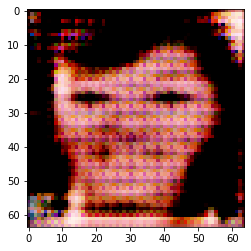

In [150]:
family_no = 1014
family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]
with tf.device('/gpu:0'):
    gen_output = encoder([father_inp, mother_inp], training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
print(np.amin(temp))
print(np.amax(temp))